# Final Project Report

* Class: DS 5100
* Student Name: Will Tenpas
* Student Net ID: wet9me
* This URL: https://github.com/willtenpas/willtenpas_ds5100_montecarlosimulator/blob/main/FinalProjectTemplate.ipynb

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Repo URL: https://github.com/willtenpas/willtenpas_ds5100_montecarlosimulator/blob/main/packages/montecarlo.py

```python
import numpy as np
import pandas as pd
import copy

class Die():
    '''This class is used to create, modify, and roll die.'''
    def __init__(self, faces):
        '''ARGS: faces, takes an np.array.
        DESCRIPTION: 
        Initializes the faces and assigns initial weights as while as checking for data types. Turns the array
        into a dataframe with faces for index and weight values, initially set to 1, in a column. Supplied array must have distinct values in string or 
        number format.'''
        # checking that it is a numpy array
        if type(faces) != type(np.array([])):
            raise TypeError("That's not an array!")
        #checking that the type of the array is string or number
        if not np.issubdtype(faces.dtype, np.str_) and not np.issubdtype(faces.dtype, np.number):
            raise TypeError("The array must have strings or numbers!")
        #checking that the array has distinct values by making array a set
        if len(faces)!=len(set(faces)):
            raise ValueError("Array must have distinct values!")
        #initializes weights to be 1 for each face
        weights = [1 for i in faces]
        #creates private DF for weights and faces
        self._die_info = pd.DataFrame({'Weights':weights}, index=faces)
    def change_weight(self, face, new_weight):
        '''ARGS: 
        face: takes str or number depending on type of faces.
        new_weight: takes number type.
        DESCRIPTION: 
        Takes the face you want to be changed and its new weight. Reassigns weights for given face values after checking their types.
        Weight must be a numeric type.'''
        if face not in self._die_info.index:
            raise IndexError("The given face value is not present in the die.")
        if not np.issubdtype(type(new_weight), np.number):
            raise TypeError("The new weight must be a numeric type.")
        self._die_info.loc[face, 'Weights'] = new_weight
    def roll_die(self, num_rolls=1):
        '''ARGS:
        num_rolls: defaults to 1, takes integer.
        DESCRIPTION:
        Rolls the dice a specified amount of times and returns an unstored list of results.'''
        return([np.random.choice(self._die_info.index, size=1, p=self._die_info['Weights'] / self._die_info['Weights'].sum())[0] for i in range(num_rolls)])
    def die_state(self):
        '''ARGS:
        none
        DESCRIPTION:
        Returns a deep copy of the die_info data frame.'''
        copy_die_info = copy.deepcopy(self._die_info)
        return(copy_die_info)

class Game():
    '''This class is used to roll multiple die of the same length at once'''
    def __init__(self, die_list):
        '''ARGS:
        die_list: list of die objects, created using Die().
        DESCRIPTION:
        Initializes game and verifies die list.'''
        self.die_list = die_list
        if not all(isinstance(die,Die) for die in die_list):
            raise ValueError("Your list doesn't have all die in it!")
        faces = die_list[0].die_state()
        face_values = set(faces.index)
        for i in die_list:
            test_faces_df = i.die_state()
            if set(test_faces_df.index)!=face_values:
                raise ValueError("The faces on your dice are different!")
    def play(self, num_rolls):
        '''ARGS:
        num_rolls: takes integer to determine how many rolls are to be conducted.
        DESCRIPTION:
        Creates a dataframe of roll results with the roll number in the index and each column representing a die object. The
        cell values then have the face rolled from each die on that roll.'''
        _results_df = pd.DataFrame(index=range(num_rolls))
        for i in range(len(self.die_list)):
            results = self.die_list[i].roll_die(num_rolls)
            _results_df[i] = results
        self._results_df = _results_df.rename_axis("Roll", axis=0)
        return(self._results_df)
    def return_play(self, format='wide'):
        '''ARGS:
        format: takes string either 'wide' or 'narrow', defaults to wide.
        DESCRIPTION:
        Returns a wide or narrow data frame with the results from the rolls. If narrow, the index is a multi index
        composed of the roll and die number.'''
        _results_df = self._results_df
        if format != 'wide' and format!='narrow':
            raise ValueError("You've supplied an invalid format type!")
        if format=='narrow':
            narrow_df = _results_df.stack()
            return(narrow_df)
        else:
            copy_roll_results = copy.deepcopy(self._results_df)
            return(copy_roll_results)

class Analyzer():
    '''The class is used to analyze played games for overall results as well as special cases'''
    def __init__(self, game):
        '''initializes the analyzer and checks for a game'''
        if not isinstance(game, Game):
            raise ValueError("You have not supplied a game!")
        self.game = game
        self.die_list = self.game.die_list
    def jackpot(self):
        '''counts how many times all the die objects were equal on the same roll'''
        _results_df = self.game._results_df
        jackpot_count = 0
        print(_results_df)
        for row in _results_df.index:
            rolls = _results_df.loc[row]
            jackpot = all(value==rolls.loc[0] == value for value in rolls)
            jackpot_count += jackpot
        return(jackpot_count)
    def facecounts(self):
        '''returns a dataframe with a count for each face and how many times it was rolled in each roll'''
        _results_df = self.game._results_df
        faces = self.die_list[0].die_state().index
        facecounts_df = pd.DataFrame(columns=faces, index = _results_df.index)
        print(faces)
        for index, roll in _results_df.iterrows():
            rolls = pd.Series(roll.values)
            counts = rolls.value_counts().reindex(facecounts_df.columns, fill_value=0)
            facecounts_df.loc[index] = counts
        return(facecounts_df)
    def combocount(self):
        '''returns a dataframe with a multi index of distinct combinations with their number of counts'''
        #combinations don't care about order so H,T is the same as T,H
        _results_df = self.game._results_df
        #sort each combo so that T,H and H,T both become H,T, then make the results a tuple
        comb_list = []
        for row in _results_df.values:
            tuprow = tuple(sorted(row))
            comb_list.append(tuprow)
        #then we create a set of this combo_list so that we only get unique combos
        unique_comb = set(comb_list)
        #now we do a count on the set and make a dictionary with the combo as the key and the count as the value
        comb_counts = {comb: comb_list.count(comb) for comb in unique_comb}
        #then we go thorugh and put this into a dataframe
        comb_df = pd.DataFrame(comb_counts.items(), columns=['Combination', 'Count'])
        return(comb_df)
    def permcount(self):
        '''returns a dataframe with a multi index of distinct permutations with their number of counts'''
        _results_df = self.game._results_df
        #need to conver each row entry into tuples, where the cell entry is an entry in the tuple
        perm_list = list(map(tuple, _results_df.values))
        #then we create a set of this perm_list so that we only get unique permutations
        unique_permutations = set(perm_list)
        #now we do a count on the set and make a dictionary with the permutation as the key and the ocunt as the value
        perm_counts = {perm: perm_list.count(perm) for perm in unique_permutations}
        #then we go thorugh and put this into a dataframe
        perm_df = pd.DataFrame(perm_counts.items(), columns=['Permutation', 'Count'])
        return(perm_df)
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import unittest
from montecarlo import Die,Game,Analyzer
import montecarlo
import numpy as np
import pandas as pd
import pandas._testing as pd_testing

class monte_test_case(unittest.TestCase):
    def setUp(self):
        self.die1 = Die(np.array([1, 2, 3, 4]))
        self.die2 = Die(np.array([1, 2, 3, 4]))
        self.die3 = Die(np.array([1, 2, 3, 4]))
        self.buggy_die = [self.die1, Die(np.array([1,2,3,5]))]
        self.game1 = Game([self.die1, self.die2])
        self.game1.play(100)
        self.anal1 = Analyzer(self.game1)
    def test_die_weights(self):
        '''test of die init to check data frame'''
        test_value = isinstance(self.die1._die_info, pd.DataFrame)
        message = 'Die initialization is not creating data frame.'
        self.assertTrue(test_value, message)
    def test_change_weight(self):
        '''test of change weight for new weight'''
        self.die1.change_weight(1,2)
        expected = pd.DataFrame({'Weights':[2,1,1,1]},index=[1,2,3,4])
        message = 'Die weights are not being changed.'
        pd_testing.assert_frame_equal(self.die1._die_info, expected, check_dtype=False, check_index_type=False)
    def test_roll(self):
        '''test of change weight for new weight'''
        test_value = type([])
        message = 'Die roll is not returning list.'
        self.assertEqual(type(self.die1.roll_die()),test_value, message)
    def test_d_state(self):
        '''test of change weight for new weight'''
        test_value = type(pd.DataFrame())
        message = 'Die roll is not returning data frame.'
        self.assertEqual(type(self.die1.die_state()),test_value, message)
    def test_g_init(self):
        '''test of game initialization to see if you get correct error'''
        message = 'Game allows you to supply improper die!'
        with self.assertRaises(ValueError) as context:
            Game(self.buggy_die)
        self.assertEqual(str(context.exception), 'The faces on your dice are different!')
    def test_play(self):
        '''test of type returned by playing game'''
        test_value = type(pd.DataFrame())
        message = 'Game play is not returning data frame.'
        self.assertEqual(type(self.game1.play(4)),test_value, message)
    def test_return_play(self):
        '''test of type returned by game play'''
        test_value = type(pd.DataFrame())
        message = 'Game play is not returning data frame.'
        self.assertEqual(type(self.game1.return_play()),test_value, message)  
    def test_anal_init(self):
        '''test of analyzer initialization to see if you can supply non games'''
        message = 'You have not supplied a game!'
        with self.assertRaises(ValueError) as context:
            Analyzer(pd.DataFrame)
        self.assertEqual(str(context.exception), 'You have not supplied a game!')
    def test_anal_jack(self):
        '''test of type returned by jackpot analyzer'''
        test_value = type(3)
        message = 'Jackpot analysis is not returning an integer!'
        self.assertEqual(type(self.anal1.jackpot()),test_value, message)
    def test_anal_face(self):
        '''test of type returned by game play'''
        test_value = type(pd.DataFrame())
        message = 'Face count analysis is not returning a dataframe!'
        self.assertEqual(type(self.anal1.facecounts()),test_value, message)
    def test_anal_comb(self):
        '''test of type returned by comb count'''
        test_value = type(pd.DataFrame())
        message = 'Comb counter analysis is not returning a dataframe!'
        self.assertEqual(type(self.anal1.combocount()),test_value, message)
    def test_anal_perm(self):
        '''test of type returned by perm count'''
        test_value = type(pd.DataFrame())
        message = 'Perm counter analysis is not returning a dataframe!'
        self.assertEqual(type(self.anal1.permcount()),test_value, message)
if __name__ =='__main__':
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

```bash
test_10_anal_face (__main__.monte_test_case)
test of type returned by game play ... Int64Index([1, 2, 3, 4], dtype='int64')
ok
test_11_anal_comb (__main__.monte_test_case)
test of type returned by comb count ... ok
test_12_anal_perm (__main__.monte_test_case)
test of type returned by perm count ... ok
test_1_die_weights (__main__.monte_test_case)
test of die init to check data frame ... ok
test_2_change_weight (__main__.monte_test_case)
test of change weight for new weight ... ok
test_3_roll (__main__.monte_test_case)
test of change weight for new weight ... ok
test_4_d_state (__main__.monte_test_case)
test of change weight for new weight ... ok
test_5_g_init (__main__.monte_test_case)
test of game initialization to see if you get correct error ... ok
test_6_play (__main__.monte_test_case)
test of type returned by playing game ... ok
test_7_return_play (__main__.monte_test_case)
test of type returned by game play ... ok
test_8_anal_init (__main__.monte_test_case)
test of analyzer initialization to see if you can supply non games ... ok
test_9_anal_jack (__main__.monte_test_case)
test of type returned by jackpot analyzer ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.536s

OK
```

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
! pip install montecarlo

In [2]:
from montecarlo.montecarlo import *
import montecarlo.montecarlo as mc

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [3]:
help(mc)

Help on module montecarlo.montecarlo in montecarlo:

NAME
    montecarlo.montecarlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  The class is used to analyze played games for overall results as well as special cases
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      ARGS:
     |      game: a single game object.
     |      DESCRIPTION:
     |      Initializes analyzer and verifies game object type.
     |  
     |  combocount(self)
     |      ARGS:
     |      none
     |      DESCRIPTION:
     |      Returns a data frame of unique combinations from the results data frame.
     |      The index is the combination and the first column is the count that that
     |      combination was rolled.
     |  
     |  facecounts(self)
     |      ARGS:
     |      none
     |      DESCRIPTION:
     |      Returns a data frame of results for each face. 

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/willtenpas/willtenpas_ds5100_montecarlosimulator/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

![Successful install](./actualsuccessfulimport.png)
![Successful result outside of folder](./successful_install.png)


# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [4]:
fair_coin = mc.Die(np.array(['H','T']))
unfair_coin = mc.Die(np.array(['H','T']))
unfair_coin.change_weight('H',5)
unfair_coin.die_state()

,Weights
H,5
T,1


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [5]:
fair_game = Game([fair_coin,fair_coin])
fair_game.play(1000)

,0,1
Roll,,
0,T,H
1,T,H
2,T,T
3,H,H
4,T,H
...,...,...
995,H,T
996,T,H
997,H,H


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [6]:
unfair_game = Game([fair_coin, unfair_coin, unfair_coin])
unfair_game.play(1000)

,0,1,2
Roll,,,
0,T,H,H
1,H,H,H
2,H,H,H
3,H,H,H
4,T,T,H
...,...,...,...
995,T,T,H
996,H,H,H
997,H,T,H


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [7]:
fair_anal = Analyzer(fair_game)
unfair_anal = Analyzer(unfair_game)
fair_jacks = fair_anal.jackpot()
unfair_jacks = unfair_anal.jackpot()
print(fair_jacks)
print(unfair_jacks)

484
364


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [8]:
fair_rel = fair_jacks/1000
unfair_rel = unfair_jacks/1000
print(fair_rel, unfair_rel)

0.484 0.364


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

<Axes: >

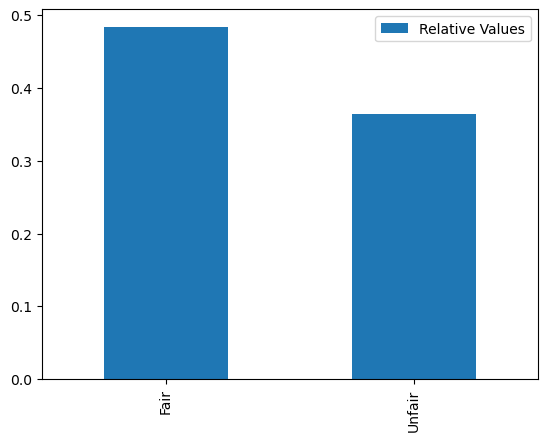

In [9]:
data = pd.DataFrame({'Relative Values':[fair_rel,unfair_rel]},index=['Fair','Unfair'])
data.plot.bar()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [10]:
die1 = Die(np.arange(1,7))
die2 = Die(np.arange(1,7))
die3 = Die(np.arange(1,7))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [11]:
die1.change_weight(6,5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [12]:
die2.change_weight(1,5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [13]:
game1 = Game([die3]*5)
game1.play(10000)

,0,1,2,3,4
Roll,,,,,
0,5,2,5,3,5
1,4,2,4,4,3
2,1,2,4,6,4
3,1,3,2,3,2
4,2,1,1,3,3
...,...,...,...,...,...
9995,2,4,6,2,2
9996,6,6,4,1,6
9997,4,6,2,6,1


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [14]:
game2 = Game([die1,die2,die3,die3,die3])
game2.play(10000)

,0,1,2,3,4
Roll,,,,,
0,6,4,4,2,2
1,3,6,2,1,4
2,6,6,2,3,4
3,4,1,5,4,1
4,4,4,3,1,5
...,...,...,...,...,...
9995,6,1,4,5,2
9996,1,1,4,6,5
9997,3,1,1,1,1


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

In [15]:
fair_die_jack = Analyzer(game1).jackpot()
unfair_die_jack = Analyzer(game2).jackpot()
print(fair_die_jack,unfair_die_jack)

11 10


<Axes: >

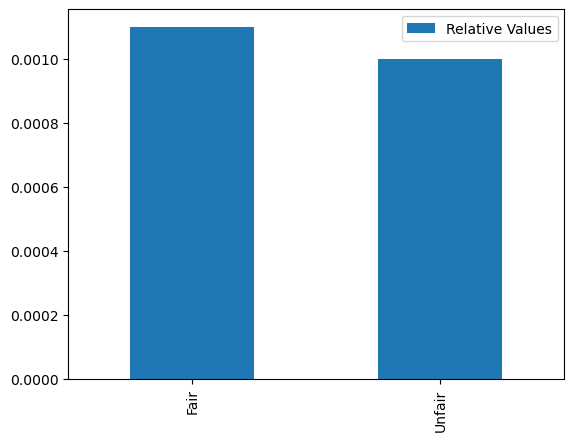

In [16]:
data = pd.DataFrame({'Relative Values':[fair_die_jack/10000,unfair_die_jack/10000]},index=['Fair','Unfair'])
data.plot.bar()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [17]:
english_letters = pd.read_csv('./english_letters.txt', sep=" ", header=None)
letters = list(english_letters[0])
weights = list(english_letters[1])
letter_die = Die(np.array(letters))
for i, letters in enumerate(letters):
    letter_die.change_weight(letters,weights[i])
letter_die._die_info

,Weights
E,529117365
T,390965105
A,374061888
O,326627740
I,320410057
N,313720540
S,294300210
R,277000841
H,216768975
L,183996130


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [18]:
letter_game = Game([letter_die]*4)
letter_game.play(1000)

,0,1,2,3
Roll,,,,
0,O,E,S,R
1,N,E,I,R
2,N,M,E,I
3,F,A,C,L
4,E,O,O,E
...,...,...,...,...
995,E,E,O,M
996,R,E,L,W
997,O,A,S,H


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [28]:
anal = Analyzer(letter_game)
perms = anal.permcount()
perms['Permutation'] = perms['Permutation'].apply(lambda x: ''.join(x))
scrab_words = pd.read_csv('./scrabble_words.txt', sep="/n", header=None)
words = perms.merge(scrab_words, left_on='Permutation', right_on=0, how='inner')
words = words[['Permutation']]
words
len(words)

/var/folders/0h/0zs91vpj1yd6d34vx_t93ssw0000gn/T/ipykernel_4888/3311520407.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  scrab_words = pd.read_csv('./scrabble_words.txt', sep="/n", header=None)


57

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [29]:
letter_game = Game([letter_die]*4)
letter_game.play(1000)
anal = Analyzer(letter_game)
perms = anal.permcount()
perms['Permutation'] = perms['Permutation'].apply(lambda x: ''.join(x))
scrab_words = pd.read_csv('./scrabble_words.txt', sep="/n", header=None)
words = perms.merge(scrab_words, left_on='Permutation', right_on=0, how='inner')
words = words[['Permutation']]
words
len(words)

/var/folders/0h/0zs91vpj1yd6d34vx_t93ssw0000gn/T/ipykernel_4888/2261833402.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  scrab_words = pd.read_csv('./scrabble_words.txt', sep="/n", header=None)


53

The five die rolls have less matched words.

# Submission

When finished completing the above tasks, save this file to your local repo (and within your project), and them push it to your GitHub repo.

Then convert this file to a PDF and submit it to GradeScope according to the assignment instructions in Canvas.